<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/03_GNN_molecular_activity_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Convolutional Networks for Molecular Property Prediction: A Comprehensive Tutorial

## Table of Contents
0. [Setup and Installation](#setup-and-installation)
1. [Introduction](#introduction)
2. [Theoretical Background: Graph Convolutional Networks](#theoretical-background-graph-convolutions-network)
3. [Implementing a GCN from Scratch](#implementing-gcn-scratch)
4. [Visualizing the GCN Layer Operations in Detail](#visualization)
5. [Building a Complete GCN for Molecular Property Prediction](#gcn-molecular-property-prediction)
6. [ Visualizing Learned Molecular Representations](#visualize-learned-representation)
7. [Conclusions](#conclusions)

## 0. Setup and Installation  <a name="setup-and-installation"></a>


In [ ]:
#@title Intstall necessary libraries
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q rdkit
!pip install -q networkx
!pip install -q jupyter-black
%load_ext jupyter_black

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.4 MB/s eta 0:00:00


In [ ]:
# @title import required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

## 1. Introduction <a name="introduction"></a>

This notebook provides a comprehensive explanation and implementation of Graph Convolutional Networks (GCNs), with a specific focus on their application to molecular property prediction. We'll start with the theoretical foundations, implement a GCN from scratch, and then use PyTorch Geometric to predict molecular properties such as binding affinity.

### Learning Objectives
- Understand the theory behind Graph Convolutional Networks (GCNs)
- Visualize how GCNs process graph-structured data in the context of molecules
- Implement a GCN from scratch using PyTorch
- Apply a GCN model to predict molecular properties using PyTorch Geometric
- Evaluate and visualize the results of molecular property prediction



## 2. Theoretical Background: Graph Convolutional Networks <a name="theoretical-background-graph-convolutions-network"> </a>

### 2.1 Graph Representation and Notation

In the context of molecules, graphs provide a natural representation where:
- Atoms are represented as nodes
- Chemical bonds are represented as edges

Mathematically, we define a graph $G = (V, E)$ where:
- $V$ is the set of nodes (atoms)
- $E$ is the set of edges (chemical bonds)

Each node $i$ has a feature vector $\mathbf{x}_i$ that could represent properties like:
- Atom type (C, N, O, etc.)
- Formal charge
- Hybridization state
- Etc.

The graph structure can be represented as an adjacency matrix $\mathbf{A}$, where:
- $\mathbf{A}_{ij} = 1$ if there is an edge between nodes $i$ and $j$
- $\mathbf{A}_{ij} = 0$ otherwise

Let's visualize these concepts:

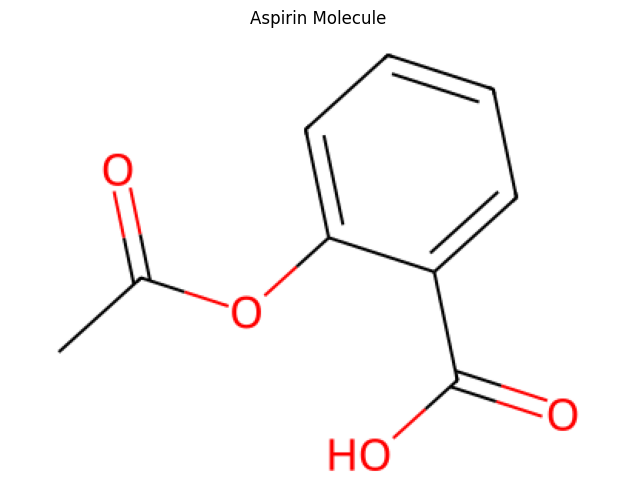

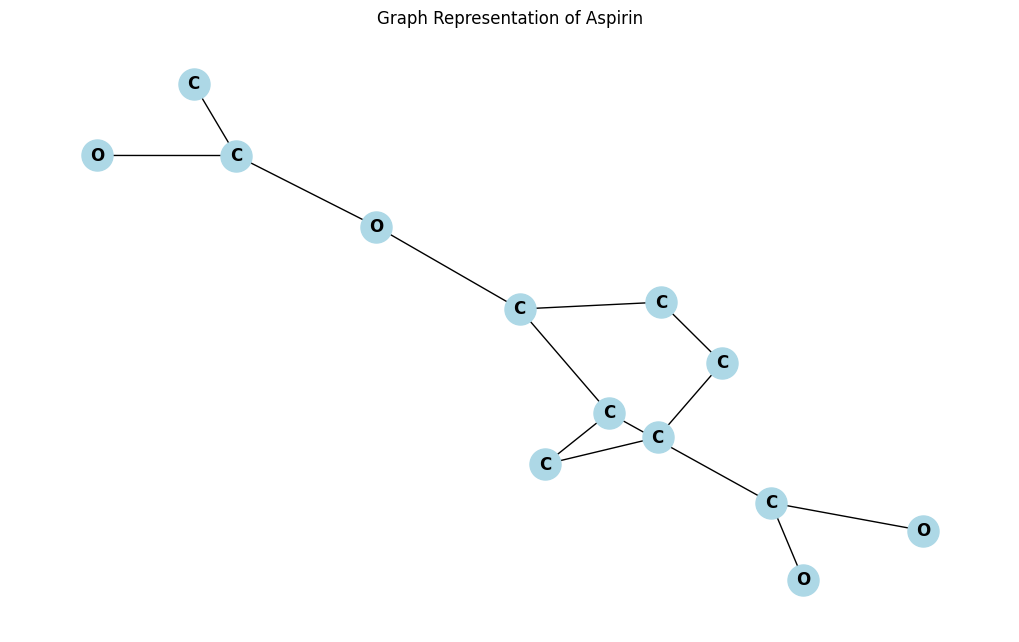

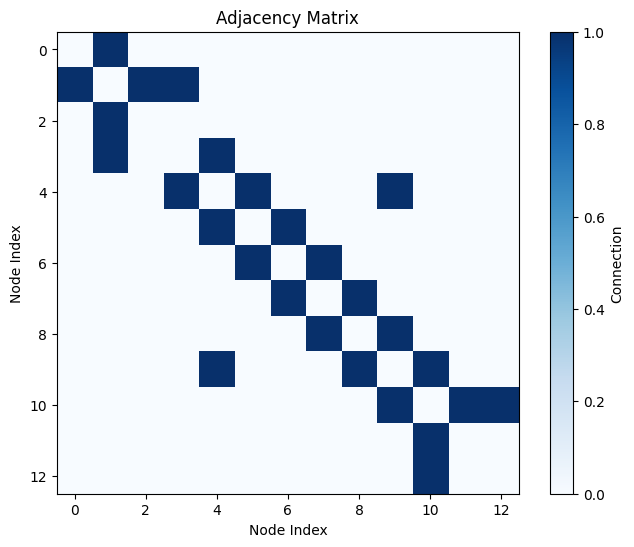

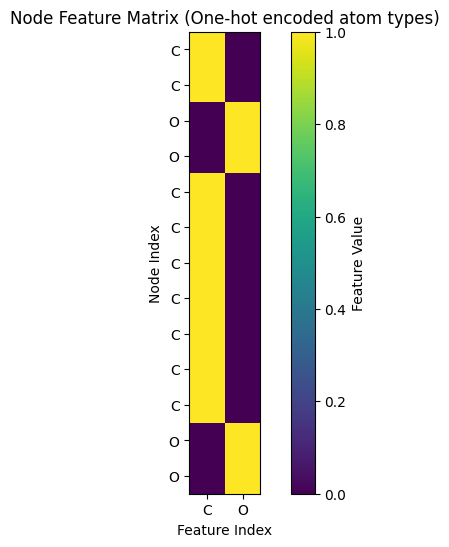

In [ ]:
# Define a simple molecule (aspirin)
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
mol = Chem.MolFromSmiles(aspirin_smiles)

# Visualize the molecule using RDKit
mol_img = Draw.MolToImage(mol, size=(400, 300))
plt.figure(figsize=(10, 6))
plt.imshow(mol_img)
plt.axis("off")
plt.title("Aspirin Molecule")
plt.show()

# Create a NetworkX graph from the molecule
G = nx.Graph()

# Add nodes (atoms)
atom_symbols = []
for atom in mol.GetAtoms():
    G.add_node(atom.GetIdx(), symbol=atom.GetSymbol())
    atom_symbols.append(atom.GetSymbol())

# Add edges (bonds)
for bond in mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

# Create a visualization
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    labels={i: atom_symbols[i] for i in range(len(atom_symbols))},
    node_color="lightblue",
    node_size=500,
    font_weight="bold",
)
plt.title("Graph Representation of Aspirin")
plt.show()

# Generate adjacency matrix
A = nx.adjacency_matrix(G).toarray()

plt.figure(figsize=(8, 6))
plt.imshow(A, cmap="Blues")
plt.colorbar(label="Connection")
plt.title("Adjacency Matrix")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

# Example node features (one-hot encoding of atom types)
unique_atoms = sorted(set(atom_symbols))
atom_to_idx = {atom: i for i, atom in enumerate(unique_atoms)}
n_atoms = len(atom_symbols)
n_features = len(unique_atoms)

X = np.zeros((n_atoms, n_features))
for i, atom in enumerate(atom_symbols):
    X[i, atom_to_idx[atom]] = 1

plt.figure(figsize=(8, 6))
plt.imshow(X, cmap="viridis")
plt.colorbar(label="Feature Value")
plt.title("Node Feature Matrix (One-hot encoded atom types)")
plt.xlabel("Feature Index")
plt.ylabel("Node Index")
plt.yticks(range(n_atoms), atom_symbols)
plt.xticks(range(n_features), unique_atoms)
plt.show()

### 2.2 Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

### 2.3 The Graph Convolutional Network Model (Kipf & Welling, 2017)

The key insight of GCNs is to perform convolution operations directly on graphs by aggregating neighboring node features. This allows for learning representations that respect the graph structure.

In the seminal paper by Thomas Kipf and Max Welling (2017), the layer-wise propagation rule for GCNs is defined as:

$$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$$

Where:
- $H^{(l)}$ is the matrix of node features at layer $l$ (with $H^{(0)} = X$)
- $\tilde{A} = A + I$ is the adjacency matrix with self-connections (identity matrix $I$)
- $\tilde{D}$ is the degree matrix of $\tilde{A}$
- $W^{(l)}$ is the weight matrix for layer $l$
- $\sigma$ is a non-linear activation function (e.g., ReLU)

1. _Compute messages / update node features_: Create a feature vector $\vec{h}_n$ for each node $n$ (e.g. with an MLP). This is going to be the message that this node will pass to neighboring nodes.
2. _Message-passing / aggregate node features_: For each node, calculate a new feature vector $\vec{h}'_n$ based on the messages (features) from the nodes in its neighborhood. In a directed graph, only nodes from incoming edges are counted as neighbors. The image below shows this aggregation step. There are multiple options for aggregation in a GCN, e.g. taking the mean, the sum, the min or max.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_conv.png" width="500px">

*\"A generic overview of a graph convolution operation, highlighting the relevant information for deriving the next-level features for every node in the graph.\"* Image source: Petar Veličković (https://github.com/PetarV-/TikZ)


Let's visualize how this works with a simple graph:

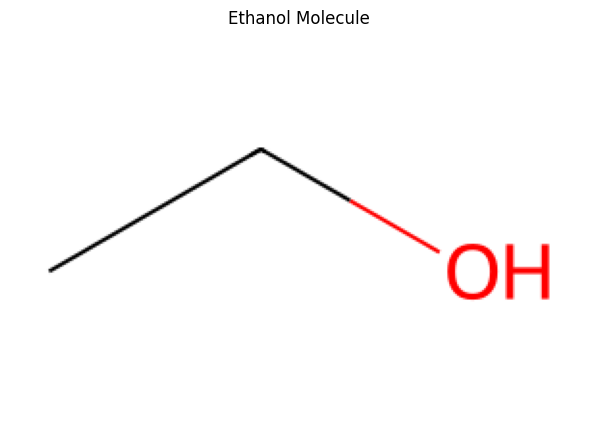

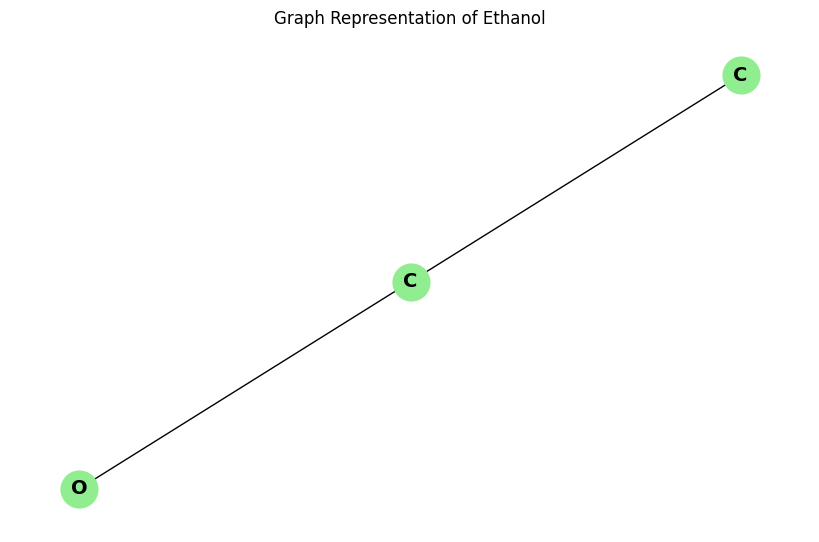

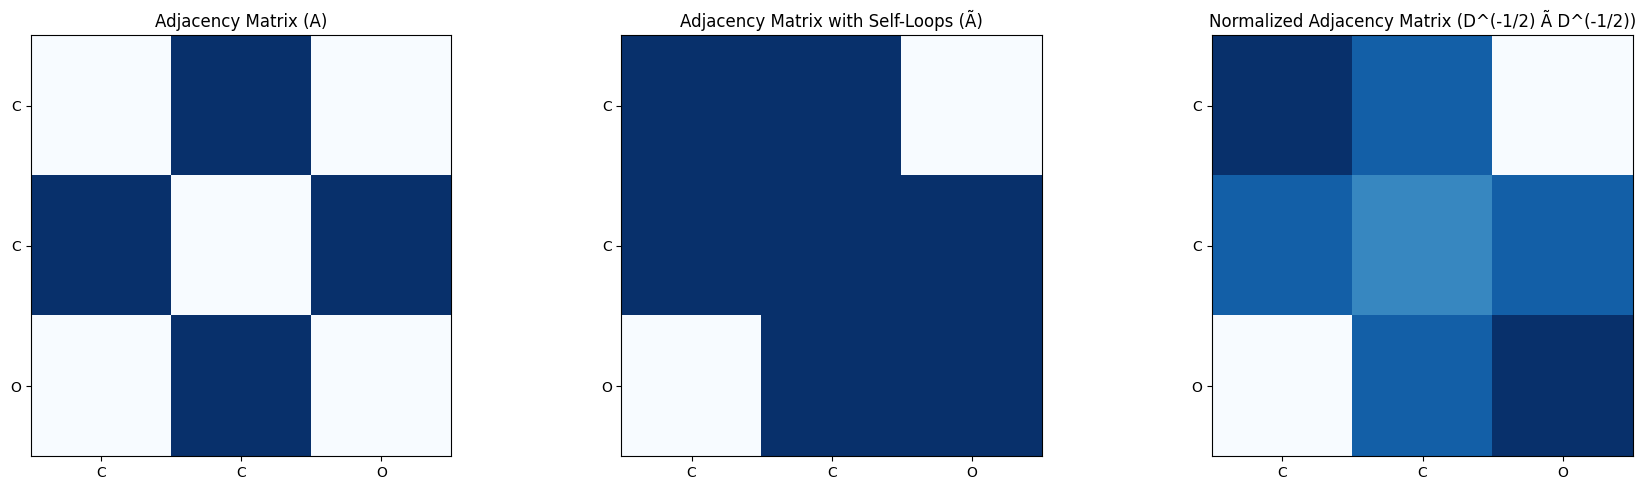

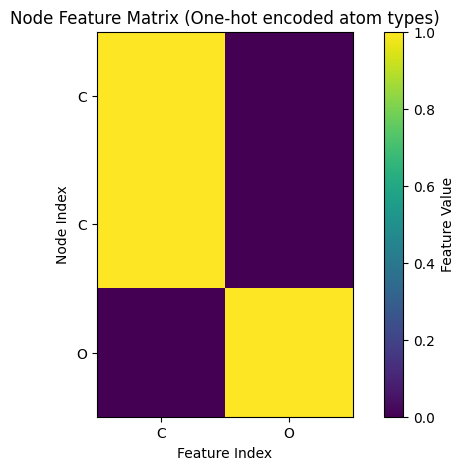

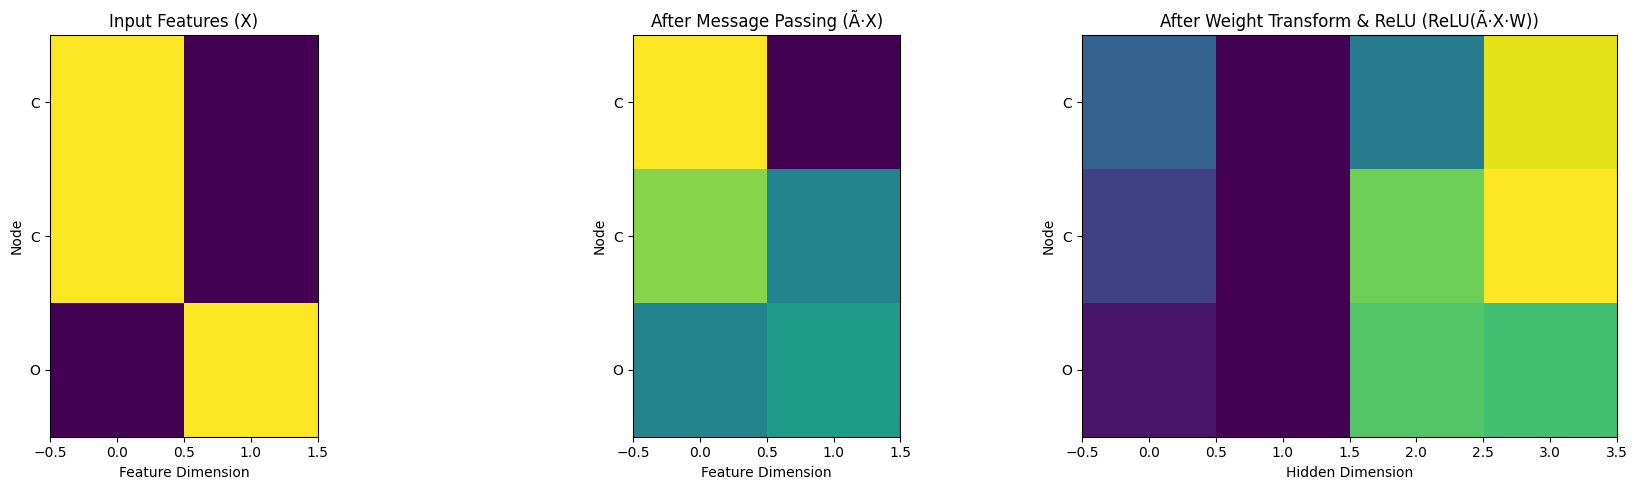

In [ ]:
# Create a simpler example for illustration
simple_mol_smiles = "CCO"  # Ethanol
simple_mol = Chem.MolFromSmiles(simple_mol_smiles)

# Visualize the molecule
simple_mol_img = Draw.MolToImage(simple_mol, size=(300, 200))
plt.figure(figsize=(8, 5))
plt.imshow(simple_mol_img)
plt.axis("off")
plt.title("Ethanol Molecule")
plt.show()

# Create a graph from the molecule
G_simple = nx.Graph()

# Add nodes (atoms)
atom_symbols_simple = []
for atom in simple_mol.GetAtoms():
    G_simple.add_node(atom.GetIdx(), symbol=atom.GetSymbol())
    atom_symbols_simple.append(atom.GetSymbol())

# Add edges (bonds)
for bond in simple_mol.GetBonds():
    G_simple.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

# Visualize the graph
plt.figure(figsize=(8, 5))
pos_simple = nx.spring_layout(G_simple, seed=42)
nx.draw(
    G_simple,
    pos_simple,
    with_labels=True,
    labels={i: atom_symbols_simple[i] for i in range(len(atom_symbols_simple))},
    node_color="lightgreen",
    node_size=700,
    font_weight="bold",
    font_size=14,
)
plt.title("Graph Representation of Ethanol")
plt.show()

# Get adjacency matrix
A_simple = nx.adjacency_matrix(G_simple).toarray()

# Calculate the normalized adjacency matrix as in GCN
A_tilde = A_simple + np.eye(A_simple.shape[0])  # Add self-loops
D_tilde = np.diag(np.sum(A_tilde, axis=1))  # Degree matrix
D_tilde_inv_sqrt = np.diag(1 / np.sqrt(np.sum(A_tilde, axis=1)))  # D^(-1/2)
normalized_A = D_tilde_inv_sqrt @ A_tilde @ D_tilde_inv_sqrt  # D^(-1/2) A D^(-1/2)

# Visualize matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(A_simple, cmap="Blues")
axes[0].set_title("Adjacency Matrix (A)")
axes[0].set_xticks(range(len(atom_symbols_simple)))
axes[0].set_yticks(range(len(atom_symbols_simple)))
axes[0].set_xticklabels(atom_symbols_simple)
axes[0].set_yticklabels(atom_symbols_simple)

axes[1].imshow(A_tilde, cmap="Blues")
axes[1].set_title("Adjacency Matrix with Self-Loops (Ã)")
axes[1].set_xticks(range(len(atom_symbols_simple)))
axes[1].set_yticks(range(len(atom_symbols_simple)))
axes[1].set_xticklabels(atom_symbols_simple)
axes[1].set_yticklabels(atom_symbols_simple)

axes[2].imshow(normalized_A, cmap="Blues")
axes[2].set_title("Normalized Adjacency Matrix (D^(-1/2) Ã D^(-1/2))")
axes[2].set_xticks(range(len(atom_symbols_simple)))
axes[2].set_yticks(range(len(atom_symbols_simple)))
axes[2].set_xticklabels(atom_symbols_simple)
axes[2].set_yticklabels(atom_symbols_simple)

plt.tight_layout()
plt.show()

# Create one-hot features for this simple molecule
unique_atoms_simple = sorted(set(atom_symbols_simple))
atom_to_idx_simple = {atom: i for i, atom in enumerate(unique_atoms_simple)}
n_atoms_simple = len(atom_symbols_simple)
n_features_simple = len(unique_atoms_simple)

X_simple = np.zeros((n_atoms_simple, n_features_simple))
for i, atom in enumerate(atom_symbols_simple):
    X_simple[i, atom_to_idx_simple[atom]] = 1

# Visualize the feature matrix
plt.figure(figsize=(8, 5))
plt.imshow(X_simple, cmap="viridis")
plt.colorbar(label="Feature Value")
plt.title("Node Feature Matrix (One-hot encoded atom types)")
plt.xlabel("Feature Index")
plt.ylabel("Node Index")
plt.yticks(range(n_atoms_simple), atom_symbols_simple)
plt.xticks(range(n_features_simple), unique_atoms_simple)
plt.show()

# Simulate a GCN layer with random weights
np.random.seed(42)
hidden_dim = 4
W = np.random.randn(n_features_simple, hidden_dim)

# GCN forward pass
H = normalized_A @ X_simple @ W
H_activated = np.maximum(0, H)  # ReLU activation

# Visualize the transformation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(X_simple, cmap="viridis")
axes[0].set_title("Input Features (X)")
axes[0].set_xlabel("Feature Dimension")
axes[0].set_ylabel("Node")
axes[0].set_yticks(range(n_atoms_simple))
axes[0].set_yticklabels(atom_symbols_simple)

axes[1].imshow(normalized_A @ X_simple, cmap="viridis")
axes[1].set_title("After Message Passing (Ã·X)")
axes[1].set_xlabel("Feature Dimension")
axes[1].set_ylabel("Node")
axes[1].set_yticks(range(n_atoms_simple))
axes[1].set_yticklabels(atom_symbols_simple)

axes[2].imshow(H_activated, cmap="viridis")
axes[2].set_title("After Weight Transform & ReLU (ReLU(Ã·X·W))")
axes[2].set_xlabel("Hidden Dimension")
axes[2].set_ylabel("Node")
axes[2].set_yticks(range(n_atoms_simple))
axes[2].set_yticklabels(atom_symbols_simple)

plt.tight_layout()
plt.show()

### 2.3 Understanding GCN Intuitively for Molecules

At the core, GCNs learn node representations by aggregating information from neighboring nodes. This is particularly well-suited for molecules because:

1. **Chemical Context**: Atoms' properties in molecules are highly influenced by their bonding environment
2. **Invariance**: The model respects the graph structure, ensuring prediction invariance to node ordering
3. **Message Passing**: Information flows along chemical bonds, mimicking how electronic effects propagate through molecules

Let's visualize the message passing process in a GCN:

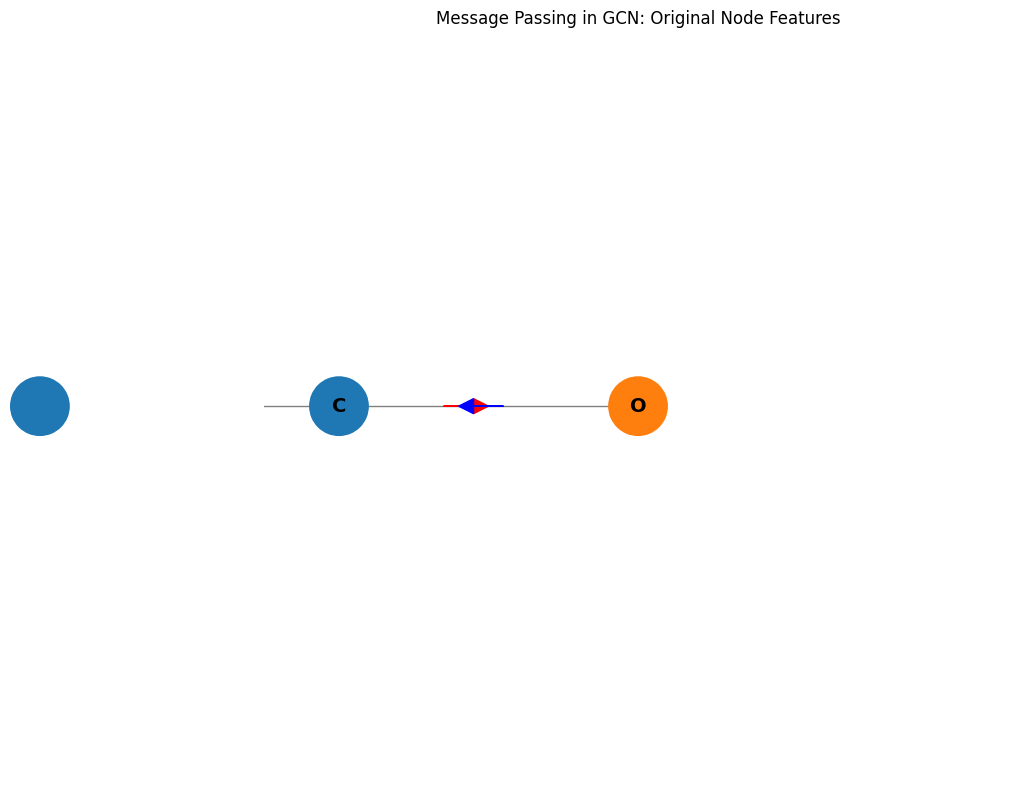

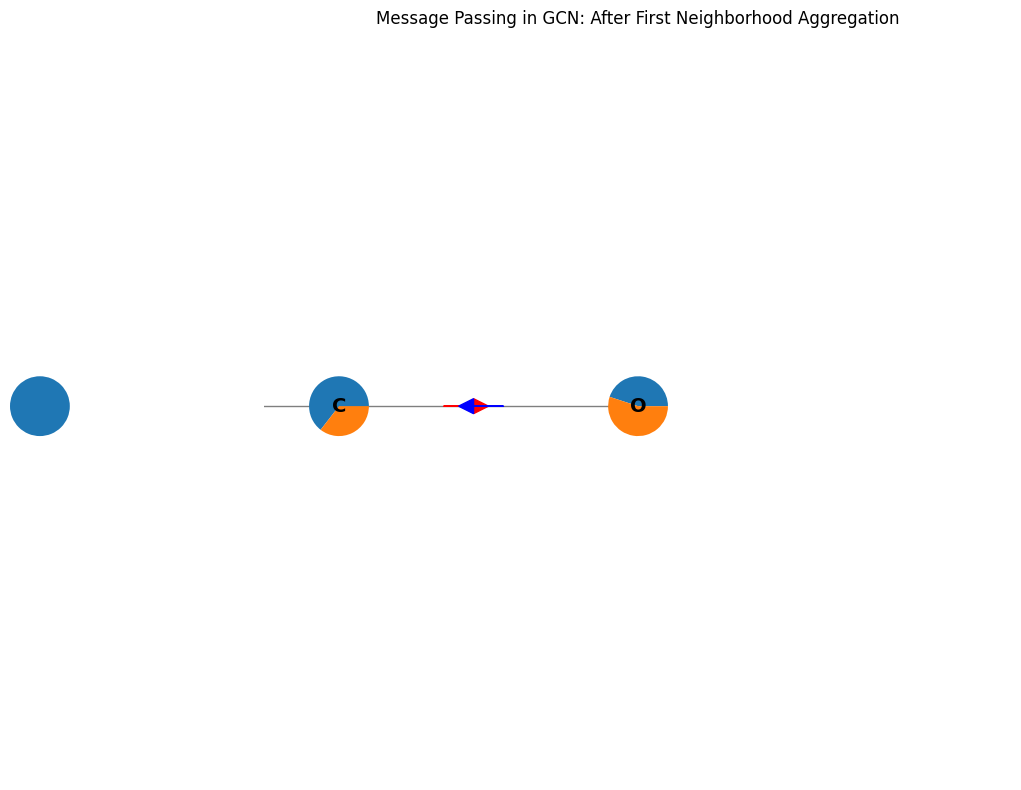

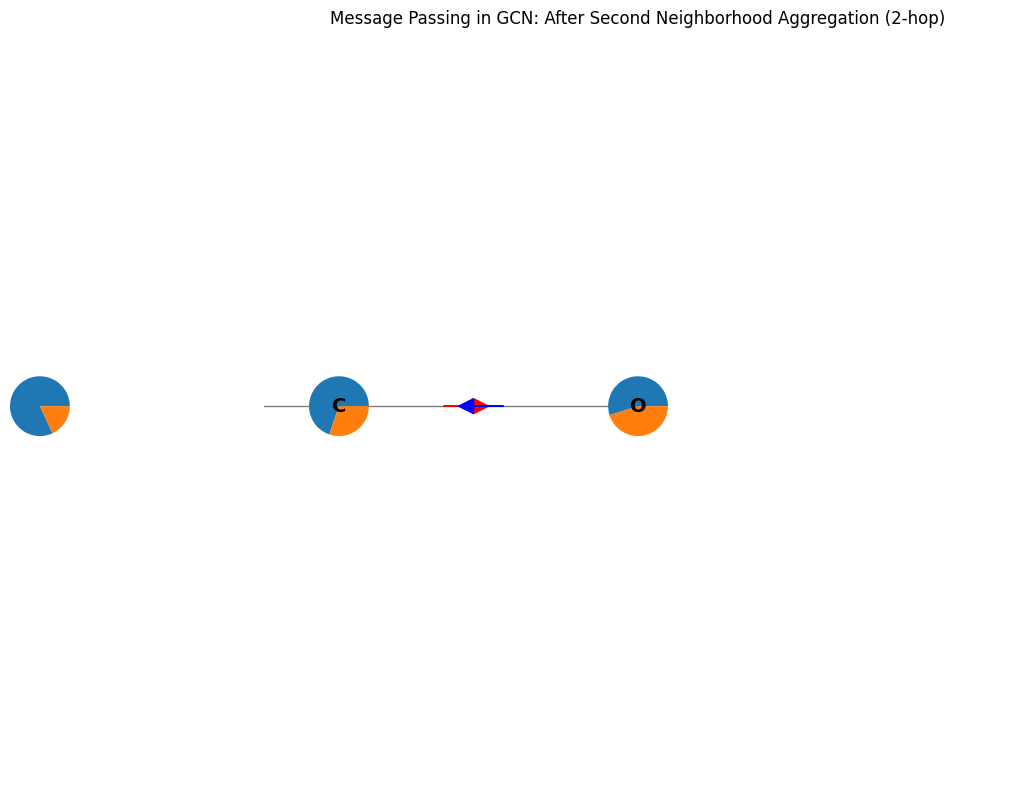

In [ ]:
def visualize_message_passing(G, pos, atom_labels, features, title):
    """Visualize the message passing mechanism."""
    n_nodes = len(G.nodes())
    plt.figure(figsize=(12, 8))

    # Draw the graph structure
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(
        G, pos, labels=atom_labels, font_size=14, font_weight="bold"
    )

    # Create a color map from features
    node_colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
    ]  # Different colors for different atom types

    # Draw nodes with their features as pie charts
    for i in range(n_nodes):
        feature = features[i]
        # Normalize features
        if np.sum(feature) > 0:
            feature = feature / np.sum(feature)

        # Draw a pie chart
        plt.pie(
            [feature[j] for j in range(len(feature))],
            colors=[node_colors[j] for j in range(len(feature))],
            center=(pos[i][0], pos[i][1]),
            radius=0.1,
        )

    # Draw arrows to represent message passing
    for u, v in G.edges():
        # Calculate the midpoint of the edge
        mid_x = (pos[u][0] + pos[v][0]) / 2
        mid_y = (pos[u][1] + pos[v][1]) / 2

        # Calculate the vector from u to v
        dx = pos[v][0] - pos[u][0]
        dy = pos[v][1] - pos[u][1]

        # Normalize the vector
        length = np.sqrt(dx**2 + dy**2)
        dx = dx / length
        dy = dy / length

        # Draw an arrow near the midpoint
        plt.arrow(
            mid_x - 0.15 * dx,
            mid_y - 0.15 * dy,
            0.1 * dx,
            0.1 * dy,
            head_width=0.05,
            head_length=0.05,
            fc="red",
            ec="red",
        )
        plt.arrow(
            mid_x + 0.05 * dx,
            mid_y + 0.05 * dy,
            -0.1 * dx,
            -0.1 * dy,
            head_width=0.05,
            head_length=0.05,
            fc="blue",
            ec="blue",
        )

    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Create a fixed position layout for our ethanol graph
pos_fixed = {0: (0, 0), 1: (1, 0), 2: (2, 0)}

# Original features
visualize_message_passing(
    G_simple,
    pos_fixed,
    {i: atom_symbols_simple[i] for i in range(len(atom_symbols_simple))},
    X_simple,
    "Message Passing in GCN: Original Node Features",
)

# After first message passing
visualize_message_passing(
    G_simple,
    pos_fixed,
    {i: atom_symbols_simple[i] for i in range(len(atom_symbols_simple))},
    normalized_A @ X_simple,
    "Message Passing in GCN: After First Neighborhood Aggregation",
)

# After second message passing (2-hop neighborhood)
visualize_message_passing(
    G_simple,
    pos_fixed,
    {i: atom_symbols_simple[i] for i in range(len(atom_symbols_simple))},
    normalized_A @ (normalized_A @ X_simple),
    "Message Passing in GCN: After Second Neighborhood Aggregation (2-hop)",
)

### 2.4 Key Advantages of GCNs for Molecular Applications

1. **Respects Molecular Structure**: Graph-based approach naturally handles the connectivity of atoms
2. **Learns Both Local and Global Features**: Can capture both local chemical environments and overall molecular structure
3. **Invariant to Atom Ordering**: Same molecule will give same prediction regardless of how atoms are indexed
4. **Handles Variable-Sized Molecules**: Can process molecules with different numbers of atoms
5. **Interpretable**: Feature maps can often be related back to chemical substructures



## 3. Implementing a GCN from Scratch <a name="implementing-gcn-scratch"></a>

Now, let's implement a GCN from scratch using PyTorch:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return (
            self.__class__.__name__
            + " ("
            + str(self.in_features)
            + " -> "
            + str(self.out_features)
            + ")"
        )


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nout, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nout)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return x


# Let's test our implementation on the simple ethanol molecule
# Convert numpy arrays to PyTorch tensors
adj_tensor = torch.FloatTensor(normalized_A)
features_tensor = torch.FloatTensor(X_simple)

# Initialize a GCN model
model = GCN(nfeat=n_features_simple, nhid=8, nout=2, dropout=0.5)
print(model)

# Forward pass
output = model(features_tensor, adj_tensor)
print("Output shape:", output.shape)
print("Output features:")
print(output)

GCN(
  (gc1): GraphConvolution (2 -> 8)
  (gc2): GraphConvolution (8 -> 2)
)
Output shape: torch.Size([3, 2])
Output features:
tensor([[0.9347, 0.9289],
        [1.0735, 1.1331],
        [0.3800, 0.4589]], grad_fn=<AddBackward0>)


## 4. Visualizing the GCN Layer Operations in Detail <a name="visualization"></a>

Let's break down the GCN operations step by step to understand what's happening inside:

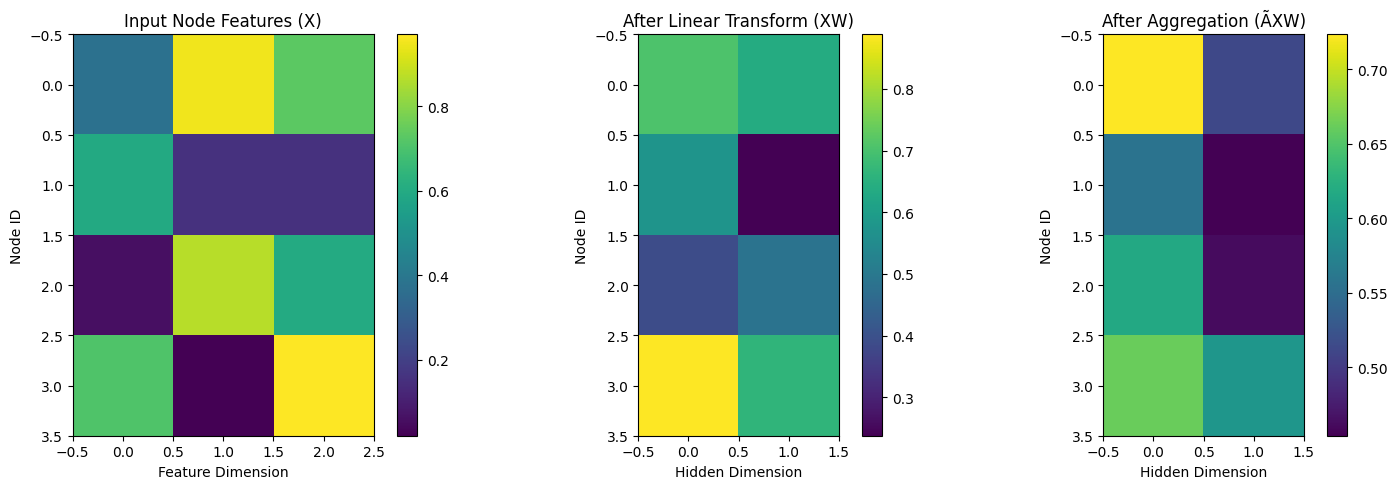

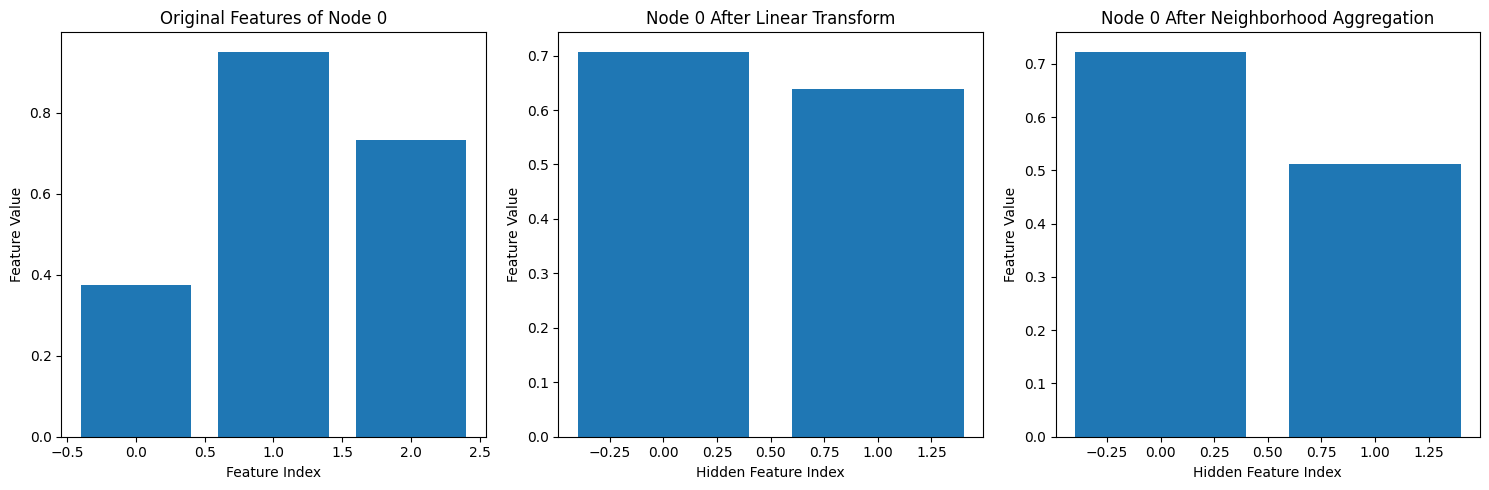

<ipython-input-7-1ff62e1cbc1c>:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


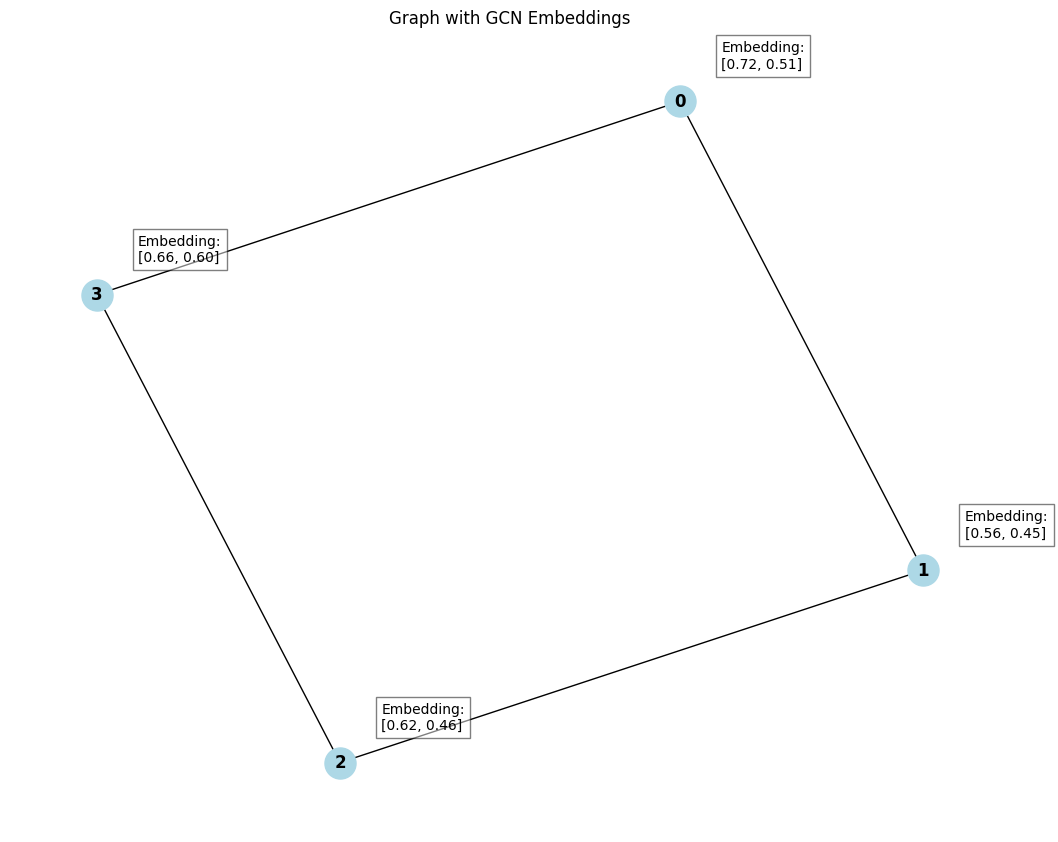

In [ ]:
# Let's use a simple artificial example
n_nodes = 4
n_features = 3

# Create a synthetic graph
G_demo = nx.cycle_graph(n_nodes)  # A cycle graph with 4 nodes
A_demo = nx.adjacency_matrix(G_demo).toarray()

# Add self-loops and normalize
A_tilde_demo = A_demo + np.eye(n_nodes)
D_tilde_demo = np.diag(np.sum(A_tilde_demo, axis=1))
D_tilde_inv_sqrt_demo = np.linalg.inv(np.sqrt(D_tilde_demo))
normalized_A_demo = D_tilde_inv_sqrt_demo @ A_tilde_demo @ D_tilde_inv_sqrt_demo

# Create random feature matrix
np.random.seed(42)
X_demo = np.random.rand(n_nodes, n_features)

# Create random weight matrix
W_demo = np.random.rand(n_features, 2)  # Output dimension is 2

# Convert to PyTorch tensors
X_demo_tensor = torch.FloatTensor(X_demo)
A_demo_tensor = torch.FloatTensor(normalized_A_demo)
W_demo_tensor = torch.FloatTensor(W_demo)

# Step 1: Linear transformation of features
linear_transform = torch.mm(X_demo_tensor, W_demo_tensor)

# Step 2: Aggregation with normalized adjacency matrix
aggregated = torch.mm(A_demo_tensor, linear_transform)

# Step 3: Apply non-linearity (ReLU)
activated = F.relu(aggregated)

# Visualize each step
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_demo, cmap="viridis")
plt.title("Input Node Features (X)")
plt.xlabel("Feature Dimension")
plt.ylabel("Node ID")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(linear_transform.numpy(), cmap="viridis")
plt.title("After Linear Transform (XW)")
plt.xlabel("Hidden Dimension")
plt.ylabel("Node ID")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(aggregated.numpy(), cmap="viridis")
plt.title("After Aggregation (ÃXW)")
plt.xlabel("Hidden Dimension")
plt.ylabel("Node ID")
plt.colorbar()

plt.tight_layout()
plt.show()

# Alternative view: Following one node through the network
node_idx = 0  # Focus on first node
plt.figure(figsize=(15, 5))

# Original feature vector for this node
plt.subplot(1, 3, 1)
plt.bar(range(n_features), X_demo[node_idx])
plt.title(f"Original Features of Node {node_idx}")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")

# After linear transform
plt.subplot(1, 3, 2)
plt.bar(range(2), linear_transform[node_idx].numpy())
plt.title(f"Node {node_idx} After Linear Transform")
plt.xlabel("Hidden Feature Index")
plt.ylabel("Feature Value")

# After aggregation with neighbors
plt.subplot(1, 3, 3)
plt.bar(range(2), aggregated[node_idx].numpy())
plt.title(f"Node {node_idx} After Neighborhood Aggregation")
plt.xlabel("Hidden Feature Index")
plt.ylabel("Feature Value")

plt.tight_layout()
plt.show()

# Visualize the graph with it's embedding
plt.figure(figsize=(10, 8))

# Draw the graph structure
pos_demo = nx.spring_layout(G_demo, seed=42)
nx.draw(
    G_demo,
    pos_demo,
    node_color="lightblue",
    node_size=500,
    with_labels=True,
    font_weight="bold",
)

# Plot the 2D embedding beside each node
offset = 0.1
for i in range(n_nodes):
    plt.text(
        pos_demo[i][0] + offset,
        pos_demo[i][1] + offset,
        f"Embedding:\n[{aggregated[i, 0]:.2f}, {aggregated[i, 1]:.2f}]",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.title("Graph with GCN Embeddings")
plt.axis("off")
plt.tight_layout()
plt.show()

## 5. Building a Complete GCN for Molecular Property Prediction <a name="gcn-molecular-property-prediction"></a>

Now that we understand the GCN architecture, let's use PyTorch Geometric (PyG) to build a complete model for molecular property prediction. We'll use the QM9 dataset, a quantum chemistry dataset of ~130k small organic molecules:

Sample from ESOL dataset:
Number of graphs in batch: 32
Node features shape: torch.Size([499, 9])
Edge index shape: torch.Size([2, 1058])
Target shape: torch.Size([32, 1])
Feature dimensions: 9
MolecularGCN(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)
Epoch: 005, Train Loss: 4.7691, Val Loss: 3.7797
Epoch: 010, Train Loss: 4.2466, Val Loss: 3.3811
Epoch: 015, Train Loss: 4.1946, Val Loss: 3.3244
Epoch: 020, Train Loss: 3.8396, Val Loss: 3.1277
Epoch: 025, Train Loss: 3.8591, Val Loss: 2.9002
Epoch: 030, Train Loss: 3.4285, Val Loss: 2.6493
Epoch: 035, Train Loss: 3.3903, Val Loss: 2.6016
Epoch: 040, Train Loss: 3.0296, Val Loss: 2.2173
Epoch: 045, Train Loss: 2.9404, Val Loss: 1.9991
Epoch: 050, Train Loss: 2.6265, Val Loss: 1.8233
Epoch: 055, Train Loss: 2.4847, Val Loss: 2.0099
Epoch: 060, Train Loss: 2.4108, Val Loss: 1.6221
E

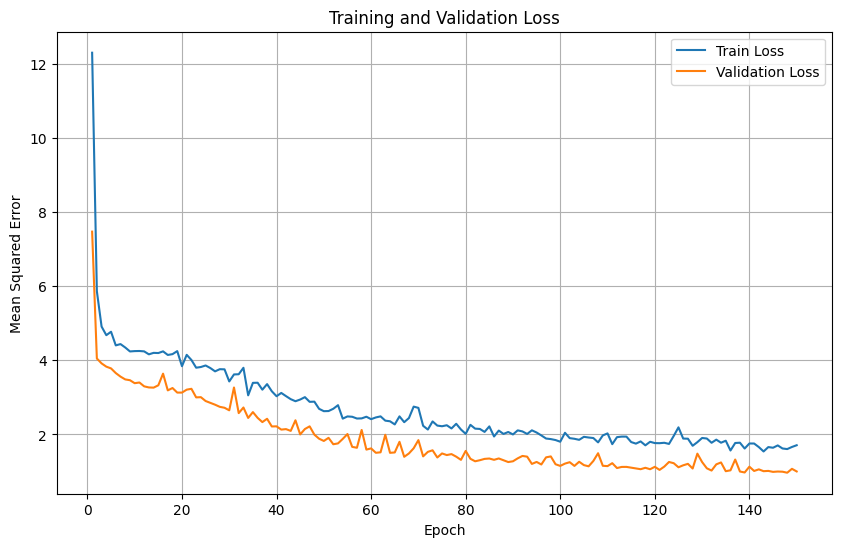

Test MAE: 0.8754
Test R²: 0.7043


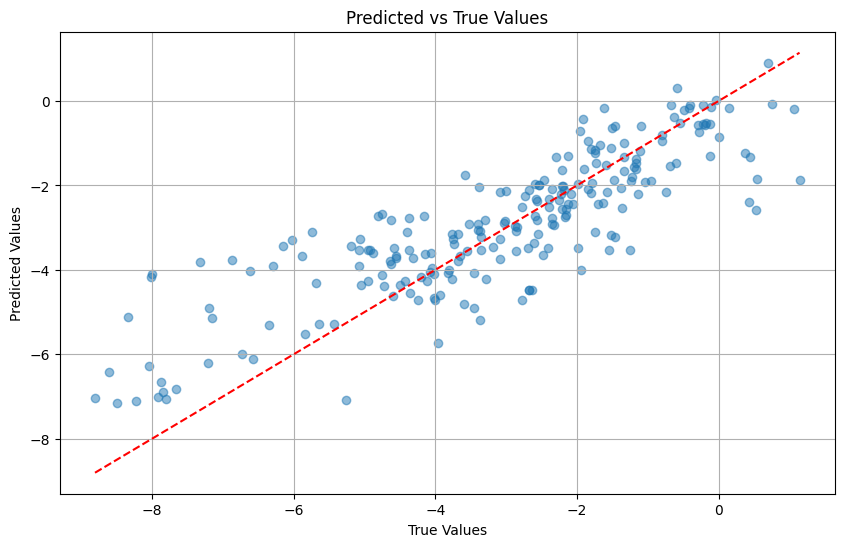

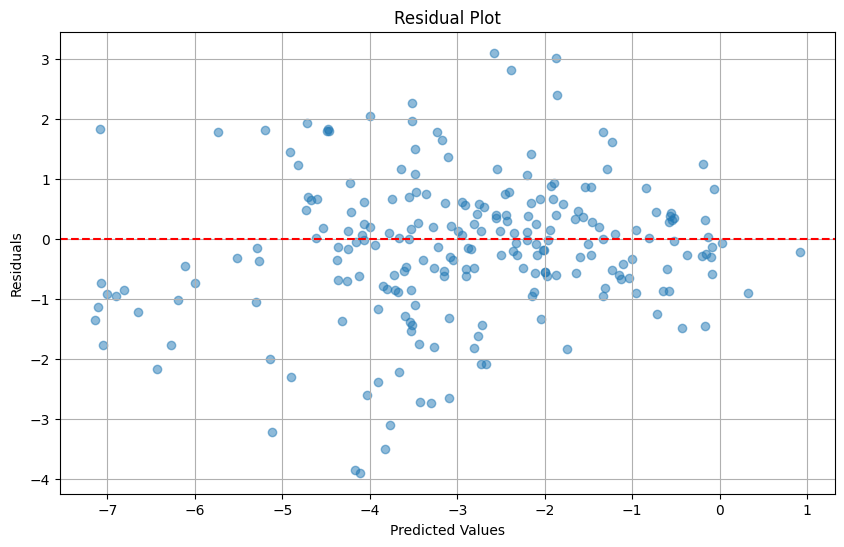

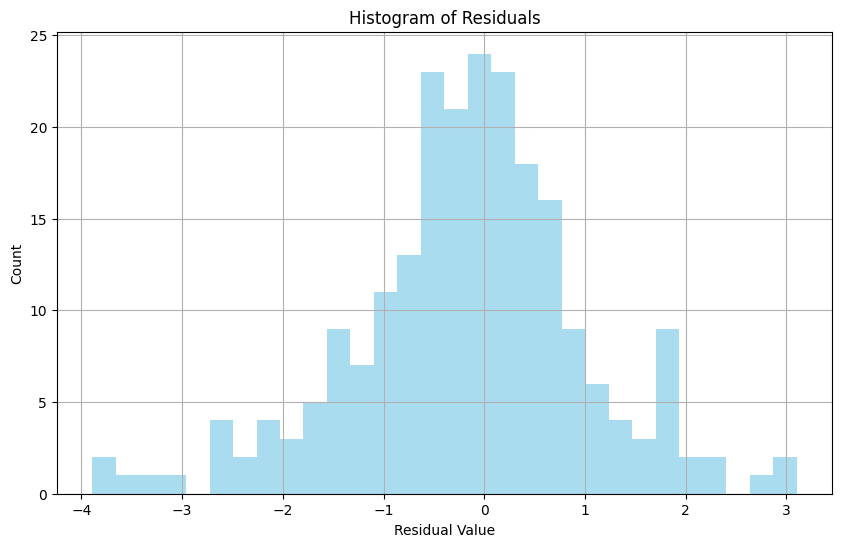

In [ ]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)

# Download and process the ESOL dataset
dataset = MoleculeNet(root="data/", name="ESOL")

# Split the dataset
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(
    train_dataset, test_size=0.1, random_state=42
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check a sample from the dataset
sample = next(iter(train_loader))
print("Sample from ESOL dataset:")
print(f"Number of graphs in batch: {sample.num_graphs}")
print(f"Node features shape: {sample.x.shape}")
print(f"Edge index shape: {sample.edge_index.shape}")
print(f"Target shape: {sample.y.shape}")
print(f"Feature dimensions: {sample.num_features}")


# Define our GCN model using PyTorch Geometric
class MolecularGCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, out_channels):
        super(MolecularGCN, self).__init__()
        # GCN layers
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels // 2)

        # Readout layers
        self.lin1 = torch.nn.Linear(hidden_channels // 2, hidden_channels // 4)
        self.lin2 = torch.nn.Linear(hidden_channels // 4, out_channels)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Global pooling (graph-level representation)
        x = global_mean_pool(x, batch)

        # Prediction head
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin2(x)

        return x


# Initialize the model
model = MolecularGCN(
    node_features=sample.num_features, hidden_channels=64, out_channels=1
)
print(model)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)


# Validation function
def validate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data.x.float(), data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(val_loader.dataset)


# Training loop
train_losses = []
val_losses = []
epochs = 150

for epoch in range(1, epochs + 1):
    train_loss = train()
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 5 == 0:
        print(
            f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        out = model(data.x.float(), data.edge_index, data.batch)
        y_true.extend(data.y.view(-1).tolist())
        y_pred.extend(out.view(-1).tolist())

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "r--")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.grid(True)
plt.show()

# Create a residual plot
residuals = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="skyblue")
plt.xlabel("Residual Value")
plt.ylabel("Count")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

## 6. Visualizing Learned Molecular Representations <a name="visualize-learned-representation"></a>

One of the advantages of GCNs is that they learn meaningful representations of molecules. Let's visualize these learned representations:

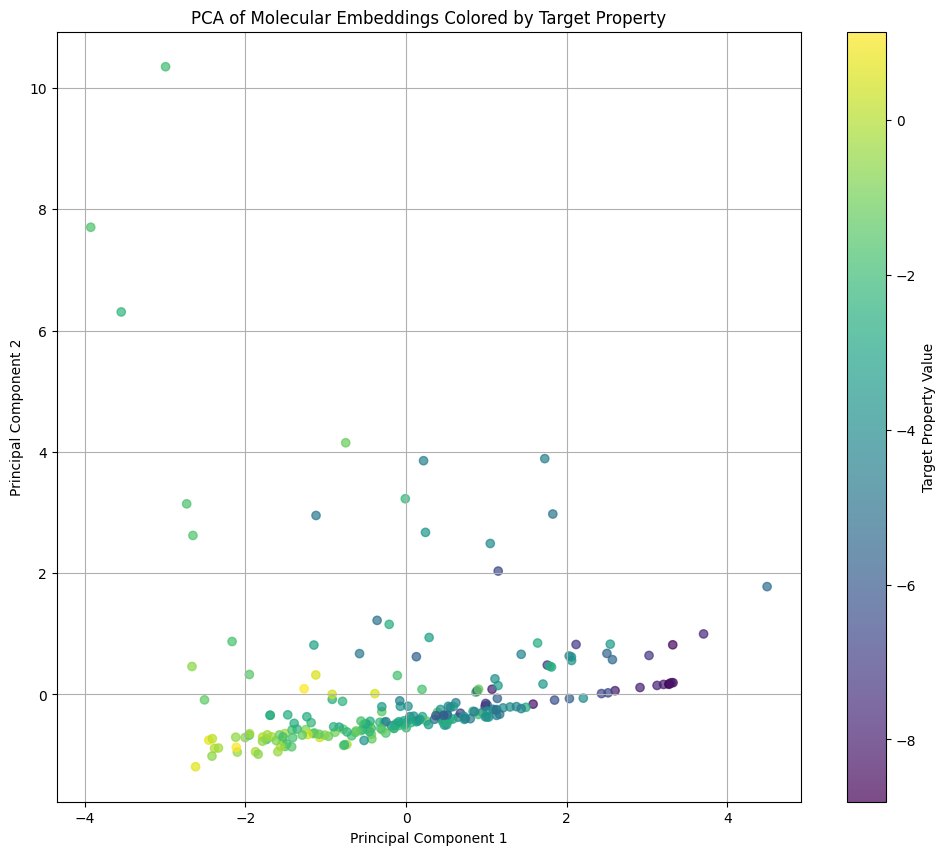

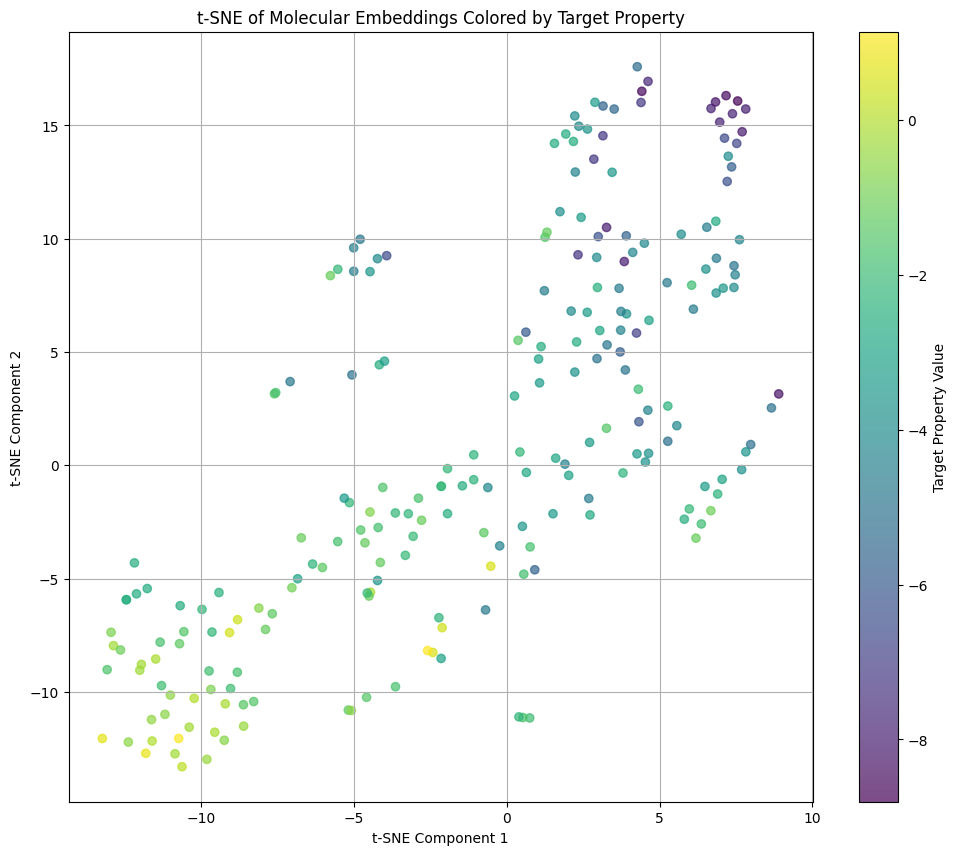

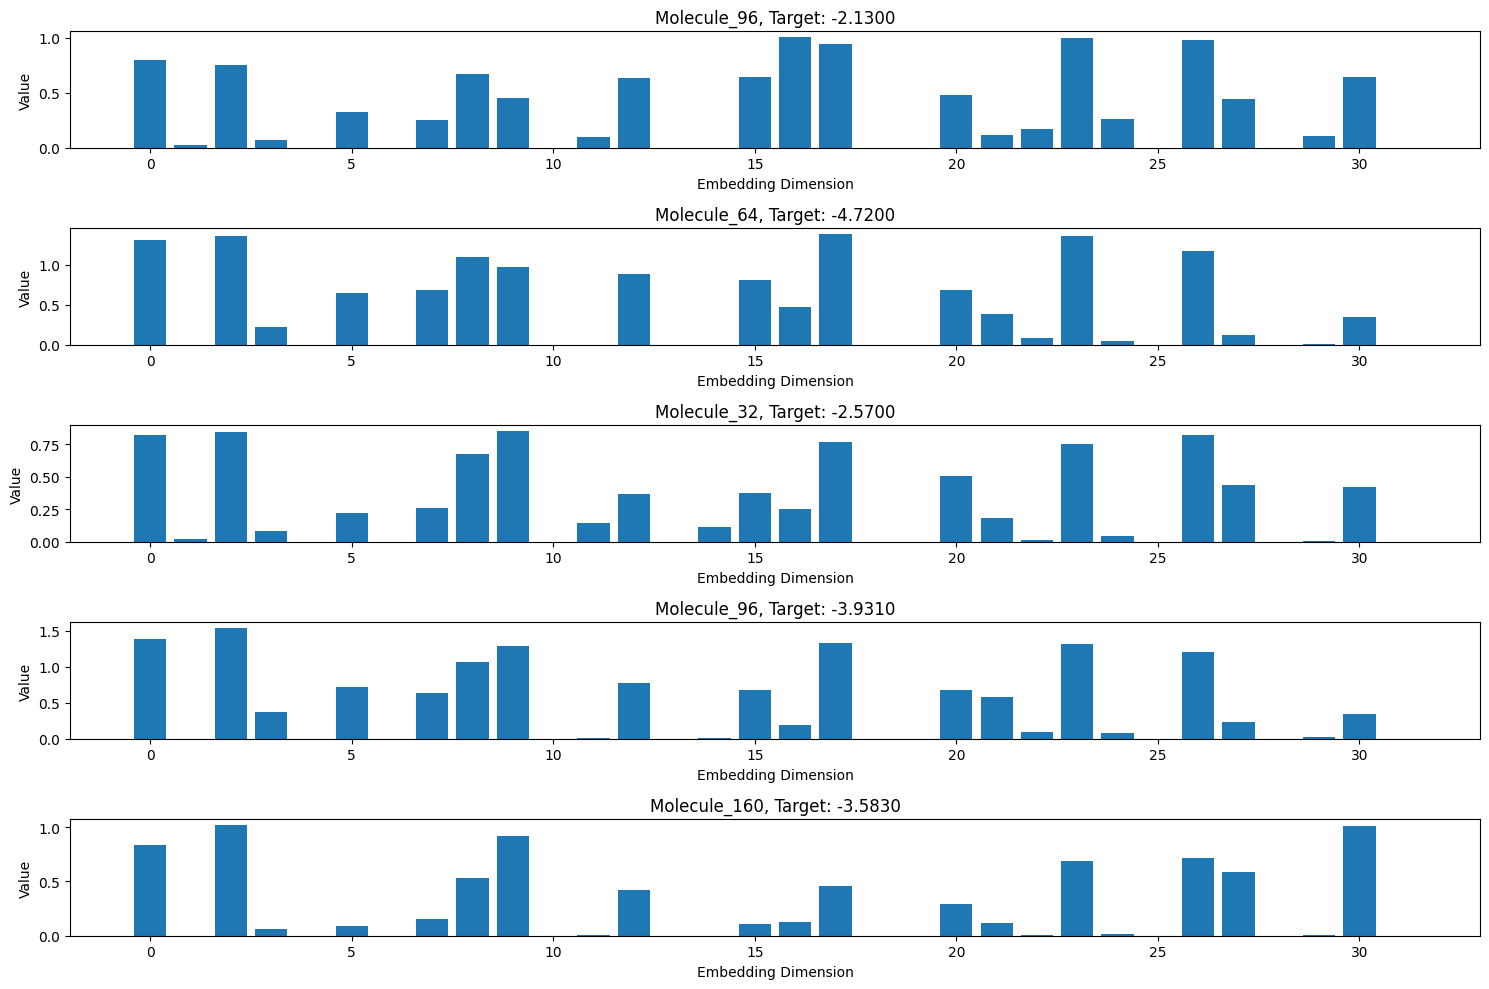

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Get embeddings for test molecules
model.eval()
embeddings = []
targets = []
molecules = []


# Function to convert a molecule to its SMILES representation
def mol_to_smiles(x, edge_index):
    # This is a simplified version - in practice you'd need to convert
    # from PyG format back to RDKit format
    # For visualization purposes, we'll just return a placeholder
    return f"Molecule_{len(embeddings)}"


with torch.no_grad():
    for data in test_loader:
        # Get intermediate representations (after the last GCN layer, before pooling)
        x = model.conv1(data.x.float(), data.edge_index)
        x = F.relu(x)
        x = model.conv2(x, data.edge_index)
        x = F.relu(x)
        x = model.conv3(x, data.edge_index)
        x = F.relu(x)

        # Pooling to get molecule-level representation
        x_mol = global_mean_pool(x, data.batch)

        # Store embeddings and targets
        embeddings.extend(x_mol.cpu().numpy())
        targets.extend(data.y.view(-1).cpu().numpy())

        # For each molecule in the batch, extract SMILES
        batch_size = data.num_graphs
        for i in range(batch_size):
            # Get indices for this molecule
            mask = data.batch == i
            x_mol = data.x[mask]
            edge_index_mol = data.edge_index[:, mask[data.edge_index[0]]]
            # Convert to SMILES (simplified)
            smiles = mol_to_smiles(x_mol, edge_index_mol)
            molecules.append(smiles)

# Convert to numpy arrays
embeddings = np.array(embeddings)
targets = np.array(targets)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Apply t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Visualize with PCA
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], c=targets, cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Target Property Value")
plt.title("PCA of Molecular Embeddings Colored by Target Property")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Visualize with t-SNE
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=targets, cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Target Property Value")
plt.title("t-SNE of Molecular Embeddings Colored by Target Property")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

# Choose a few representative molecules and visualize their embeddings
# In a real application, you would use actual molecular structures
selected_indices = np.random.choice(len(embeddings), 5, replace=False)
selected_embeddings = embeddings[selected_indices]
selected_targets = targets[selected_indices]
selected_molecules = [molecules[i] for i in selected_indices]

# Create a bar plot of the embeddings for these molecules
plt.figure(figsize=(15, 10))
for i, (embedding, molecule, target) in enumerate(
    zip(selected_embeddings, selected_molecules, selected_targets)
):
    plt.subplot(len(selected_embeddings), 1, i + 1)
    plt.bar(range(len(embedding)), embedding)
    plt.title(f"{molecule}, Target: {target:.4f}")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

## 7. Conclusion and Future Directions <a name="conclusions"></a>

### Key Takeaways

1. **Graph Convolutional Networks** provide a powerful framework for molecular property prediction by directly operating on the molecular graph structure.

2. **Message Passing Mechanism** in GCNs effectively captures both local chemical environments and global molecular properties.

3. **Node Features** represent atom properties, while edges represent bonds, making GCNs a natural fit for molecular representation.

4. **Architecture Variations** such as attention mechanisms and edge feature incorporation can further improve predictive performance.

5. **Real-world Applications** like molecular solubility prediction demonstrate the practical utility of GCNs in drug discovery and materials science.

### Future Directions

1. **3D Information Integration**: Extending GCNs to incorporate 3D structural information using geometric graph neural networks.

2. **Multi-task Learning**: Training GCNs to predict multiple molecular properties simultaneously, leveraging shared representations.

3. **Transfer Learning**: Pre-training GCNs on large molecular databases and fine-tuning for specific prediction tasks.

4. **Interpretability**: Developing methods to interpret what GCNs learn about molecular structures and properties.

5. **Reaction and Interaction Modeling**: Extending beyond single molecules to model chemical reactions and protein-ligand interactions.

### Additional Resources for Further Learning

- **Papers**:
  - Kipf, T. N., & Welling, M. (2017). Semi-supervised classification with graph convolutional networks.
  - Gilmer, J., et al. (2017). Neural message passing for quantum chemistry.
  - Yang, K., et al. (2019). Analyzing learned molecular representations for property prediction.

- **Libraries**:
  - PyTorch Geometric: https://pytorch-geometric.readthedocs.io/
  - DeepChem: https://deepchem.io/
  - RDKit: https://www.rdkit.org/

- **Datasets**:
  - MoleculeNet: Benchmark datasets for molecular machine learning